<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1><h1>Capstone project </h1>

The goal of this project is to build a cracks classifier. The initial dataset contains 40000 images of wall from a turkish university. Half of them are cracks and the others are normal wall pictures.
To tackles this task, three methods will be used. First, we will try a linear regression. Then, we will create a convolutionnal neural network. Finally, we will use transfer learning and the ResNet18 network.

This first and the third part are the original Capstone project of the specialization IBM AI Engineering. I added the second part to better understand how CNN work. I also added the possibility of using less samples to train the models, in order to see how it affects their performance and execution speed. Since the accuracy is very high, reducing the number of samples in the training set was a way to see how robust the models when only few datas are available or when you need to train your model quickly.

<h2 id="download_data">Download Data</h2>

Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:

In [1]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

--2020-06-17 16:34:02--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
ERROR: cannot verify s3-api.us-geo.objectstorage.softlayer.net's certificate, issued by 'CN=DigiCert SHA2 Secure Server CA,O=DigiCert Inc,C=US':
  Self-signed certificate encountered.
To connect to s3-api.us-geo.objectstorage.softlayer.net insecurely, use `--no-check-certificate'.


In [2]:
!unzip -q Positive_tensors.zip

In [3]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2020-06-17 13:12:42--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

100%[====================================>] 2,111,408,108 45.5MB/s   in 43s    

2020-06-17 13:13:26 (47.0 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



We will install torchvision:

In [4]:
!pip install torchvision

     |████████████████████████████████| 6.6MB 8.3MB/s eta 0:00:01
     |████████████████████████████████| 752.0MB 20kB/s s eta 0:00:01     |███████▍                        | 174.6MB 33.8MB/s eta 0:00:18     |█████████████▌                  | 316.8MB 31.9MB/s eta 0:00:14     |██████████████▏                 | 331.9MB 28.4MB/s eta 0:00:15     |██████████████▍                 | 339.1MB 28.4MB/s eta 0:00:15/s eta 0:00:11/s eta 0:00:19��█▋              | 414.4MB 19.8MB/s eta 0:00:18     |████████████████████████▎       | 570.0MB 35.0MB/s eta 0:00:06ta 0:00:01�██▏| 731.8MB 31.5MB/s eta 0:00:01


<h2 id="auxiliary">Imports and Auxiliary Functions</h2>

The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.

In [5]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [6]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->

<h2 id="data_class">Dataset Class</h2>

 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.
 Note that whatever the size you choose, test set will always contain at least 2000 samples.

In [7]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None, train=True, size=40000):
        directory="/home/dsxuser/work"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if size > 8000 :
            if train:
                self.all_files=self.all_files[0:int(size*0.75)]
                self.Y=self.Y[0:int(size*0.75)]
                self.len=len(self.all_files)
            else:
                self.all_files=self.all_files[int(size*0.75):]
                self.Y=self.Y[int(size*0.75):]
                self.len=len(self.all_files)
        else :
            if train:
                self.all_files=self.all_files[0:size]
                self.Y=self.Y[0:size]
                self.len=len(self.all_files)
            else:
                self.all_files=self.all_files[size:size+2000]
                self.Y=self.Y[size:size+2000]
                self.len=len(self.all_files)
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

    
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

We also define two types of transformations. The first one will be used to normalize datas from RGB picture. The second one will be used to turn 3-colors images into a greyscale image.

In [ ]:
Normalize_RGB = transforms.Compose([transforms.Normalize(mean = [0.]*3, std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                            transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [1.]*3)])
Make_Grey = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(), transforms.ToTensor()])
# Grey normalization currently not available

# Linear classifier

In [16]:
from torch import optim
torch.manual_seed(0)

In [12]:
class SoftMax(nn.Module):
    
    def __init__(self,input_size,output_size):
        super(SoftMax,self).__init__()
        self.linear=nn.Linear(input_size,output_size)
    
    # Choose the function
    def forward(self,x):
        yhat = self.linear(x)
        return yhat

Then, we create two datatsets, one for training and another for testing.

In [55]:
# Choose a transformation
trans = Normalize_RGB
dataset_size = 5000
batch_size = 100

train_dataset = Dataset(train=True, transform = trans, size=dataset_size)
validation_dataset = Dataset(train=False, transform = trans, size=dataset_size)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = batch_size)

We create the model and choose an optimizer and a loss function.

In [56]:
size_of_image=3*224*224

model = SoftMax(size_of_image,2)
optimizer = optim.SGD(model.parameters(), lr = 0.1)
criterion = nn.CrossEntropyLoss()

We can now train and evaluate the model.

In [57]:
n_epochs = 10

for epoch in range(n_epochs) :
    for x,y in train_loader :
        yhat = model(x.view(-1,size_of_image))
        loss = criterion(yhat,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    correct = 0
    for x_test, y_test in validation_loader:
        z = model(x_test.view(-1, size_of_image))
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
        
    accuracy = correct / len(validation_dataset)
    print("Epoch", epoch+1, "   Loss :", loss.data.item(), "   Accuracy :", accuracy, "\n")

Epoch 1    Loss : 1755.147216796875    Accuracy : 0.5 

Epoch 2    Loss : 2883.08837890625    Accuracy : 0.825 

Epoch 3    Loss : 2705.599365234375    Accuracy : 0.7945 

Epoch 4    Loss : 2474.93212890625    Accuracy : 0.4835 

Epoch 5    Loss : 2338.917724609375    Accuracy : 0.4905 

Epoch 6    Loss : 2239.927490234375    Accuracy : 0.528 

Epoch 7    Loss : 241.49903869628906    Accuracy : 0.504 

Epoch 8    Loss : 284.20819091796875    Accuracy : 0.5115 

Epoch 9    Loss : 557.0035400390625    Accuracy : 0.5235 

Epoch 10    Loss : 885.4318237304688    Accuracy : 0.5415 



# Convolutional neural network

In this part, we will use a convolutional neural network to improve the performance of the classifier. In order to test several network architecture, we define a general function that can create customized network.

In [39]:
def Create_Network(image_size, input_channels, num_of_layers, num_of_kernel,
                   kernel_size, stride_size, kernel_mp_size, stride_mp_size) :
    network = []
    in_chan = input_channels
    out_chan = num_of_kernel
    dim = image_size
    for i in range(num_of_layers) :
        network.append(nn.Conv2d(in_channels = in_chan, out_channels = out_chan, kernel_size = kernel_size[i], stride = stride_size[i]))
        dim = 1 + int((dim - kernel_size[i])/stride_size[i])
        network.append(nn.MaxPool2d(kernel_size = kernel_mp_size[i], stride = stride_mp_size[i]))
        dim = 1 + int((dim - kernel_mp_size[i])/stride_mp_size[i])
        in_chan = out_chan
        out_chan = out_chan*2
    network.append(nn.Flatten())
    network.append(nn.Linear(in_chan*dim*dim,2))

    model = nn.Sequential(*network)
    
    return model

The next function will be used to train and evaluate the model created.

In [48]:
def train_test_model(model, criterion, optimizer, train_loader, validation_loader, epochs) :
    ACC = np.zeros(epochs)
    for i in range(epochs) :
        LOSS = []
        model.train()
        for x,y in train_loader :
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z,y)
            loss.backward()
            optimizer.step()
            LOSS.append(loss.data)

        correct = 0
        model.eval()
        for x,y in validation_loader :
            z = model(x)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y).sum().item()
        accuracy = correct / len(validation_dataset)
        print("Epoch", i, "   Accuracy :", accuracy)
        ACC[i] = accuracy
    
    return model, ACC, LOSS

In [ ]:
Now, we can create the datasets.

In [42]:
# Choose a transformation
trans = Normalize_RGB
dataset_size = 500
batch_size = 10

train_dataset = Dataset(train=True, transform = trans, size=dataset_size)
validation_dataset = Dataset(train=False, transform = trans, size=dataset_size)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = batch_size)

Thanks to the function Create_Model, we can easily choose a specific architecture and test several ones.

In [49]:
### Parameters
input_channels = 3        # Grayscale or Color
num_of_layers = 3         # Number of layers
num_of_kernel = 8         # Number of kernels
kernel_size = [7,5,3]           # kernels dimensions
stride_size = [3,2,1]
kernel_mp_size = [5,3,3]           # Max pooling filters dimensions
stride_mp_size = [2,1,1]
image_size = 224

model = Create_Network(image_size, input_channels, num_of_layers, num_of_kernel,
                   kernel_size, stride_size, kernel_mp_size, stride_mp_size)

The model is ready to be trained.

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
epochs = 10

### Display results
model, Accuracies, Loss = train_test_model(model, criterion, optimizer, train_loader, validation_loader, epochs)

print("best accuracy :", np.max(Accuracies))
print("mean accuracy :", np.mean(Accuracies))

Epoch 0    Accuracy : 0.8785
Epoch 1    Accuracy : 0.893
Epoch 2    Accuracy : 0.574
Epoch 3    Accuracy : 0.508
Epoch 4    Accuracy : 0.799
Epoch 5    Accuracy : 0.9405
Epoch 6    Accuracy : 0.891
Epoch 7    Accuracy : 0.8925
Epoch 8    Accuracy : 0.952
Epoch 9    Accuracy : 0.9185
best accuracy : 0.952
mean accuracy : 0.8247


After some tests, a 3-layer neural network can achieve 90% accuracy with only 100 images.

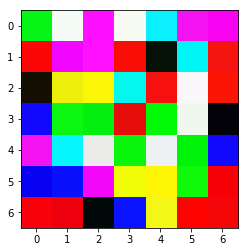

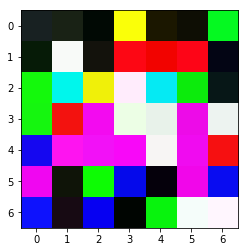

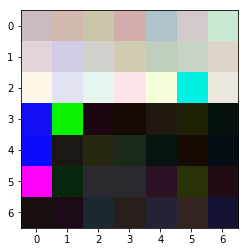

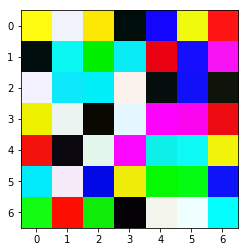

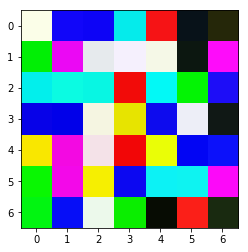

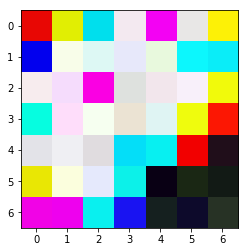

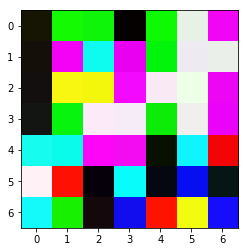

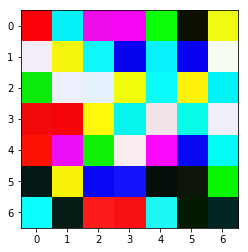

In [51]:
### Display the filters of the first hidden layer
for i in range(8) :
    plt.imshow(transforms.ToPILImage()(model[0].weight[i]))
    plt.show()

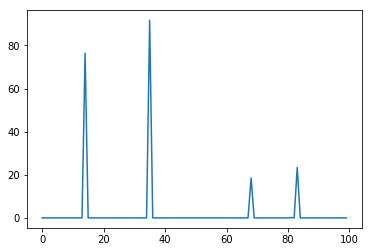

In [52]:
### Display LOSS function
plt.plot(Loss)
plt.show()

# ResNet18

In order to improve the accuracy of the classifier, we will try a transfer learning method. The purpose of transfer learning is to use very deep and computationaly expansive networks without training them. Indeed, they have already been trained on millions of datas by organizations with a lot of computing power. ResNet18 has been trained on more than a million images and is very accurate to classify images. Consequently, our only task will be to add and train a linear layer at the end of the network to classify cracks.

<b>Prepare a pre-trained resnet18 model :</b>

<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:

In [58]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/dsxuser/.cache/torch/checkpoints/resnet18-5c106cde.pth


<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.

In [59]:
for param in model.parameters() :
    param.requires_grad = False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 

<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.

In [60]:
model.fc = nn.Linear(512,2)

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>

In [61]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2>Train the Model</h2>

<b>Step 1</b>: Create a cross entropy criterion function 

In [65]:
criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.

In [66]:
# Choose a transformation
trans = Normalize_RGB
dataset_size = 500
batch_size = 10

train_dataset = Dataset(train=True, transform = trans, size=dataset_size)
validation_dataset = Dataset(train=False, transform = trans, size=dataset_size)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = batch_size)

<b>Step 3</b>: Use the following optimizer to minimize the loss 

In [67]:
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=0.001)

<!--Empty Space for separating topics-->

**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**

In [68]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    
    model.train()
    for x, y in train_loader:
        #clear gradient
        optimizer.zero_grad()
        #make a prediction
        z = model(x)
        # calculate loss
        loss = criterion(z,y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
        loss_list.append(loss.data)
        
    correct=0
    model.eval()
    for x_test, y_test in validation_loader:
        #make a prediction 
        z = model(x_test)
        #find max
        _, yhat = torch.max(z.data,1)
        #Calculate misclassified  samples in mini-batch 
        correct += (yhat == y_test).sum().item()
        
    accuracy=correct/N_test
    accuracy_list.append(accuracy)

<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>

In [313]:
print("Accuracy :", accuracy_list)

Accuracy : [0.4862944162436548, 0.4761421319796954, 0.483248730964467, 0.48020304568527916, 0.48223350253807107, 0.4812182741116751, 0.4842639593908629, 0.4842639593908629]


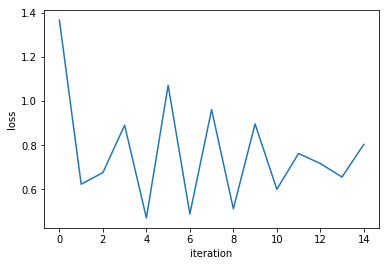

In [309]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()

<h2 id="Question_3">Question 3:Find the misclassified samples</h2> 

<b>Identify the first four misclassified samples using the validation data:</b>

Sample 177
Predicted value : 0    Probability : 0.5298303365707397
Actual value : 1


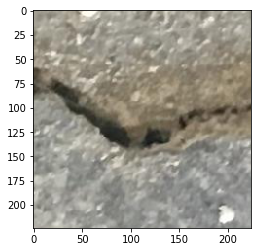

Sample 597
Predicted value : 0    Probability : 0.5909803509712219
Actual value : 1


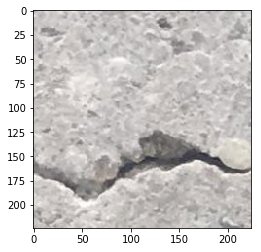

Sample 753
Predicted value : 0    Probability : 0.7160652875900269
Actual value : 1


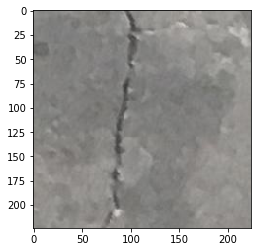

Sample 921
Predicted value : 0    Probability : 0.8811490535736084
Actual value : 1


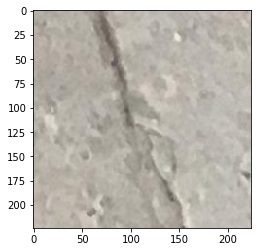

In [59]:
# Remove normalization
InvNorm = transforms.Compose([ transforms.Normalize(mean = [0.]*3, std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [1.]*3) ])

Softmax_fn=nn.Softmax(dim=-1)
count = 0
k = 0
for x,y in DataLoader(dataset = validation_dataset, batch_size = 1) :
    k += 1
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y :
        x_denorm = InvNorm(x[0]) #original values restored
        original_image = transforms.ToPILImage()(x_denorm) #tensor x truned into an image
        print("Sample",k)
        print("Predicted value :", yhat.item(), "   Probability :", torch.max(Softmax_fn(z)).item())
        print("Actual value :", y.item())
        plt.imshow(original_image)
        plt.show()
        count += 1
    if count >= 4:
        break

<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/share-notebooks.html"> CLICK HERE </a> Click here to see how to share your notebook.

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.